In [85]:
import lasio
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

In [86]:
selected_columns = [
    "YYYY/MM/DD",
    "HH:MM:SS",
    "Hole Depth (feet)",
    "Bit Depth (feet)",
    "Rate Of Penetration (ft_per_hr)",
    "Weight on Bit (klbs)",
    "Hook Load (klbs)",
    "Rotary RPM (RPM)",
    "Standpipe Pressure (psi)",
    "Rotary Torque (kft_lb)",
    "Differential Pressure (psi)",
    "Flow (flow_percent)",
    "Total Pump Output (gal_per_min)",
    "Pason Gas (percent)",
    "On Bottom (unitless)",
    "Hole Diameter (in)",
    "Bit RPM (RPM)",
    "Bit Torque (kft_lb)",
    "EDR Instantaneous ROP (ft_per_hr)",
    "On Bottom ROP (ft_per_hr)",
    "Surface Stick Slip Index (percent)",
    "MWD Temp (Fahrenheit)",
    "Azimuth (degrees)",
    "Inclination (degrees)",
    "Temp IN (Degrees)",
    "Temp OUT (Degrees)",
    "AutoDriller WOB (klbs)",
    "AutoDriller Torque (kft_lb)",
    "Top Drive Rotary (RPM)",
    "Top Drive Torque (kft_lb)",
    "DAS BHA Stick Slip (unitless)",
    "DAS Bit Stick Slip (unitless)",
    "DAS MSE (ksi)",
    "DAS Downhole MSE (ksi)",
    "DAS ROP (ft_per_hr)",
    "DAS Recommended DIFFP (psi)",
    "DAS Recommended ROP (ft_per_hr)",
    "DAS Recommended RPM (RPM)",
    "DAS Recommended WOB (klbs)",
    "Depth of Cut (in)",
    "dexponent (log)",
    "Mechanical Specific Energy (ksi)",
    "TTS Mechanical Specific Energy (ksi)",
    "Relative MSE (unitless)"
]


In [87]:
df1=pd.read_csv("27029986-3.csv", usecols=selected_columns)
df2=pd.read_csv("27029986-4.csv", usecols=selected_columns)
df3=pd.read_csv("27029986-5.csv", usecols=selected_columns)
df4=pd.read_csv("27029986-6.csv", usecols=selected_columns)

## Continiuty check over the dataframes

In [88]:
for idx, data in enumerate([df1,df2,df3,df4]):
    print(f"Dataframe N{idx}")
    print("___________________")
    print("Size:", data.size)
    print("Shape:", data.shape)
    print("\n")

Dataframe N0
___________________
Size: 25819552
Shape: (586808, 44)


Dataframe N1
___________________
Size: 26580004
Shape: (604091, 44)


Dataframe N2
___________________
Size: 26518492
Shape: (602693, 44)


Dataframe N3
___________________
Size: 31353960
Shape: (712590, 44)




In [89]:
df_list=[df1,df2,df3,df4]

for df in df_list:
    print("Record")
    print("Start Date: ", df["YYYY/MM/DD"][0])
    print("End Date: ",   df["YYYY/MM/DD"][df.shape[0]-1])
    print("Start Hole Depth: ", df["Hole Depth (feet)"][0])
    print("End Hole Depth: ", df["Hole Depth (feet)"][df.shape[0]-1])
    print("____________________________")


Record
Start Date:  2021/02/08
End Date:  2021/02/14
Start Hole Depth:  174.5
End Hole Depth:  4701.7
____________________________
Record
Start Date:  2021/02/15
End Date:  2021/02/21
Start Hole Depth:  4702.0
End Hole Depth:  7620.0
____________________________
Record
Start Date:  2021/02/22
End Date:  2021/02/28
Start Hole Depth:  7620.0
End Hole Depth:  9145.0
____________________________
Record
Start Date:  2021/03/01
End Date:  2021/03/09
Start Hole Depth:  9145.0
End Hole Depth:  9034.0
____________________________


### CONCATING ALL RECORDS

In [90]:
df=pd.concat([df1,df2,df3,df4], ignore_index=True)
df.head()

,YYYY/MM/DD,HH:MM:SS,Hole Depth (feet),Bit Depth (feet),Rate Of Penetration (ft_per_hr),Weight on Bit (klbs),Hook Load (klbs),Rotary RPM (RPM),Standpipe Pressure (psi),Rotary Torque (kft_lb),Differential Pressure (psi),Flow (flow_percent),Total Pump Output (gal_per_min),Pason Gas (percent),AutoDriller Torque (kft_lb),AutoDriller WOB (klbs),Azimuth (degrees),Bit RPM (RPM),Bit Torque (kft_lb),DAS BHA Stick Slip (unitless),DAS Bit Stick Slip (unitless),DAS Downhole MSE (ksi),DAS MSE (ksi),DAS Recommended DIFFP (psi),DAS Recommended ROP (ft_per_hr),DAS Recommended RPM (RPM),DAS Recommended WOB (klbs),DAS ROP (ft_per_hr),Depth of Cut (in),dexponent (log),EDR Instantaneous ROP (ft_per_hr),Hole Diameter (in),Inclination (degrees),Mechanical Specific Energy (ksi),MWD Temp (Fahrenheit),On Bottom (unitless),On Bottom ROP (ft_per_hr),Relative MSE (unitless),Surface Stick Slip Index (percent),Temp IN (Degrees),Temp OUT (Degrees),Top Drive Rotary (RPM),Top Drive Torque (kft_lb),TTS Mechanical Specific Energy (ksi)
0,2021/02/08,04:30:00,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,-999.25,0.005,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,0.0,0.0,-999.25,-999.25,41.96,42.44,0.0,0.005,-999.25
1,2021/02/08,04:30:01,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,-999.25,0.005,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,0.0,0.0,-999.25,-999.25,41.96,42.44,0.0,0.005,-999.25
2,2021/02/08,04:30:02,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,-999.25,0.005,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,0.0,0.0,-999.25,-999.25,41.96,42.44,0.0,0.005,-999.25
3,2021/02/08,04:30:03,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,-999.25,0.005,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,0.0,0.0,-999.25,-999.25,41.96,42.44,0.0,0.005,-999.25
4,2021/02/08,04:30:04,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,-999.25,0.005,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,0.0,-999.25,0.0,-999.25,-999.25,-999.25,-999.25,0.0,0.0,-999.25,-999.25,41.98,42.51,0.0,0.005,-999.25


## Data Cleaning

- Missing data cleaning
- Duplication check
- Imputation

In [91]:
df.isnull().sum()

YYYY/MM/DD                              0
HH:MM:SS                                0
Hole Depth (feet)                       0
Bit Depth (feet)                        0
Rate Of Penetration (ft_per_hr)         0
Weight on Bit (klbs)                    0
Hook Load (klbs)                        0
Rotary RPM (RPM)                        0
Standpipe Pressure (psi)                0
Rotary Torque (kft_lb)                  0
Differential Pressure (psi)             0
Flow (flow_percent)                     0
Total Pump Output (gal_per_min)         0
Pason Gas (percent)                     0
AutoDriller Torque (kft_lb)             0
AutoDriller WOB (klbs)                  0
Azimuth (degrees)                       0
Bit RPM (RPM)                           0
Bit Torque (kft_lb)                     0
DAS BHA Stick Slip (unitless)           0
DAS Bit Stick Slip (unitless)           0
DAS Downhole MSE (ksi)                  0
DAS MSE (ksi)                           0
DAS Recommended DIFFP (psi)       

### Note 1 

- Currently it shows that there is no null value, but there are. -999.99 or similar value is a classic placeholder for missing or invalid sensor readings. First, I will first replace only -999.25 values with 0. Then, I will check new minimum values.
- MSE related columns are important predictors, therefore we have to start from them.

In [92]:
df_1=pd.DataFrame(df['DAS MSE (ksi)'].value_counts())
df_2=pd.DataFrame(df['DAS Downhole MSE (ksi)'].value_counts())

display(df_1.head())
display(df_2.head())

,count
DAS MSE (ksi),
-999.250,1818687
0.294,1470
0.292,1410
0.293,1370
0.297,1330


,count
DAS Downhole MSE (ksi),
-999.250,1790962
0.288,12525
0.289,12151
0.287,11915
0.286,11279


## Note 2:

- In both columns,  1790962 records out of 2506182 are -999.25 values. As mentioned before, these are null value and needs to be cleaned.

In [95]:
df['DAS MSE (ksi)']=df['DAS MSE (ksi)'].replace(-999.250, np.nan)
df['DAS Downhole MSE (ksi)']=df['DAS Downhole MSE (ksi)'].replace(-999.250, np.nan)

In [97]:
print(f"number of null values - Downhole MSE: {df['DAS Downhole MSE (ksi)'].isnull().sum()}")
print(f"number of null values - MSE: {df['DAS MSE (ksi)'].isnull().sum()}")


number of null values - Downhole MSE: 1790962
number of null values - MSE: 1818687


## Note 3

- Now all -999.250 values were converted to NaN. In below, we will use boolean masking technique to filter the null values out.

In [98]:
df_mse=df[~df['DAS Downhole MSE (ksi)'].isnull()]

In [100]:
df_mse.head()

,YYYY/MM/DD,HH:MM:SS,Hole Depth (feet),Bit Depth (feet),Rate Of Penetration (ft_per_hr),Weight on Bit (klbs),Hook Load (klbs),Rotary RPM (RPM),Standpipe Pressure (psi),Rotary Torque (kft_lb),Differential Pressure (psi),Flow (flow_percent),Total Pump Output (gal_per_min),Pason Gas (percent),AutoDriller Torque (kft_lb),AutoDriller WOB (klbs),Azimuth (degrees),Bit RPM (RPM),Bit Torque (kft_lb),DAS BHA Stick Slip (unitless),DAS Bit Stick Slip (unitless),DAS Downhole MSE (ksi),DAS MSE (ksi),DAS Recommended DIFFP (psi),DAS Recommended ROP (ft_per_hr),DAS Recommended RPM (RPM),DAS Recommended WOB (klbs),DAS ROP (ft_per_hr),Depth of Cut (in),dexponent (log),EDR Instantaneous ROP (ft_per_hr),Hole Diameter (in),Inclination (degrees),Mechanical Specific Energy (ksi),MWD Temp (Fahrenheit),On Bottom (unitless),On Bottom ROP (ft_per_hr),Relative MSE (unitless),Surface Stick Slip Index (percent),Temp IN (Degrees),Temp OUT (Degrees),Top Drive Rotary (RPM),Top Drive Torque (kft_lb),TTS Mechanical Specific Energy (ksi)
198656,2021/02/10,11:40:56,3278.2,3278.2,131.46,35.6,109.9,99.08,3297.40,12.562,470.08,99.91,818.45,-999.25,12.562,36.72,-999.25,232.0,0.0,0.122,0.052,0.116,10.033,-999.25,-999.25,-999.25,-999.25,124.787,0.115,1.14,131.461,12.5,-999.25,0.3,-999.25,1.0,131.46,471.0,-999.25,52.45,130.07,99.0,12.562,0.0
198657,2021/02/10,11:40:57,3278.2,3278.2,129.34,35.4,110.7,99.05,3297.58,12.787,470.25,99.74,819.46,-999.25,12.816,35.58,-999.25,230.0,0.0,0.122,0.052,0.116,10.033,-999.25,-999.25,-999.25,-999.25,124.787,0.113,1.13,129.344,12.5,-999.25,0.3,-999.25,1.0,129.34,486.0,-999.25,52.45,130.13,99.0,12.816,0.0
198658,2021/02/10,11:40:58,3278.3,3278.3,127.30,35.4,110.2,99.05,3287.95,12.487,460.62,99.65,818.50,-999.25,12.446,36.32,-999.25,230.0,0.0,0.122,0.052,0.116,10.033,-999.25,-999.25,-999.25,-999.25,124.787,0.111,1.14,127.300,12.5,-999.25,0.3,-999.25,1.0,127.30,483.0,-999.25,52.45,130.13,99.0,12.446,0.0
198659,2021/02/10,11:40:59,3278.3,3278.3,125.42,36.3,110.2,99.05,3297.03,11.997,469.70,99.66,820.47,-999.25,11.922,35.73,-999.25,230.0,0.0,0.122,0.052,0.116,10.033,-999.25,-999.25,-999.25,-999.25,124.787,0.109,1.15,125.416,12.5,-999.25,0.3,-999.25,1.0,125.42,480.0,-999.25,52.45,130.13,99.0,11.922,0.0
198660,2021/02/10,11:41:00,3278.3,3278.3,123.19,35.9,110.7,99.05,3300.27,11.824,472.95,99.56,817.49,-999.25,11.925,36.24,-999.25,230.0,0.0,0.122,0.052,0.116,10.033,-999.25,-999.25,-999.25,-999.25,124.787,0.107,1.15,123.190,12.5,-999.25,0.3,-999.25,1.0,123.19,472.0,-999.25,52.45,130.20,99.0,11.925,0.0


In [105]:
print(df_mse['DAS Downhole MSE (ksi)'].min())
print(df_mse['DAS Downhole MSE (ksi)'].max())

0.004
49.247


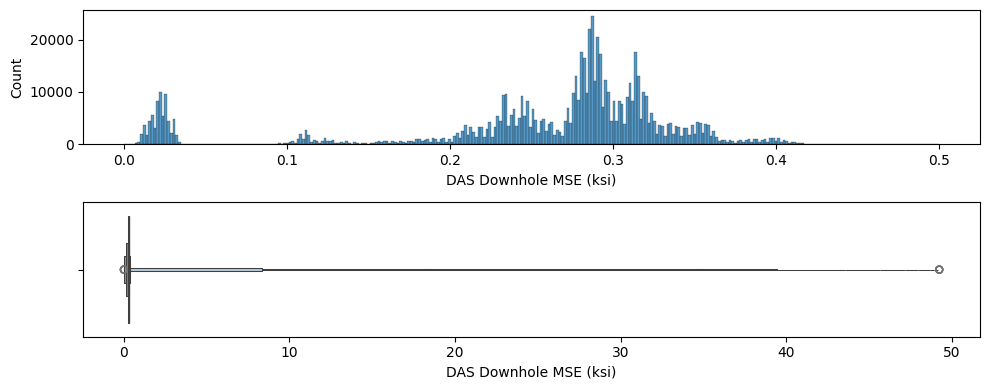

In [129]:
fig, axes=plt.subplots(2,1, figsize=(10,4))

sns.histplot(data=df_mse, x=df_mse['DAS Downhole MSE (ksi)'], ax=axes[0], binrange=(0,0.5))
sns.boxenplot(data=df_mse, x=df_mse['DAS Downhole MSE (ksi)'], ax=axes[1])

plt.tight_layout()
plt.show()

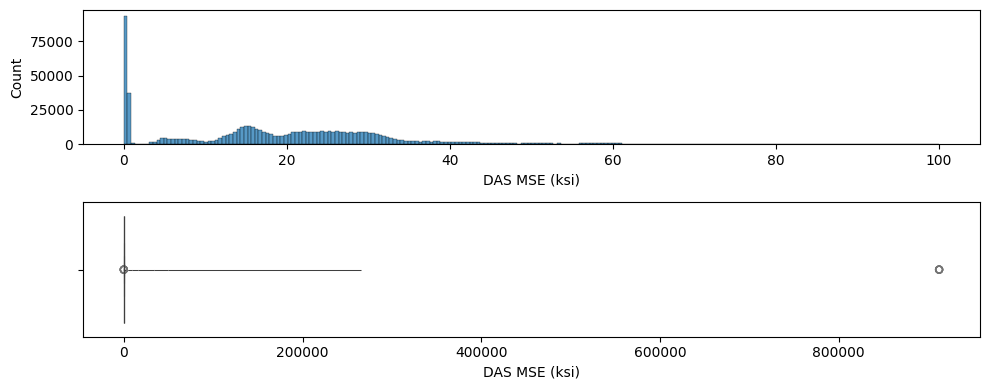

In [134]:
fig, axes=plt.subplots(2,1, figsize=(10,4))

sns.histplot(data=df_mse, x=df_mse['DAS MSE (ksi)'], ax=axes[0], binrange=(0,100))
sns.boxenplot(data=df_mse, x=df_mse['DAS MSE (ksi)'], ax=axes[1])


plt.tight_layout()
plt.show()

In [135]:
df_mse.iloc[10]

YYYY/MM/DD                              2021/02/10
HH:MM:SS                                  11:41:06
Hole Depth (feet)                           3278.5
Bit Depth (feet)                            3278.5
Rate Of Penetration (ft_per_hr)             115.96
Weight on Bit (klbs)                          36.4
Hook Load (klbs)                             109.6
Rotary RPM (RPM)                             99.17
Standpipe Pressure (psi)                   3294.47
Rotary Torque (kft_lb)                      12.319
Differential Pressure (psi)                 467.15
Flow (flow_percent)                          99.79
Total Pump Output (gal_per_min)             823.41
Pason Gas (percent)                        -999.25
AutoDriller Torque (kft_lb)                 12.395
AutoDriller WOB (klbs)                       36.38
Azimuth (degrees)                          -999.25
Bit RPM (RPM)                                231.0
Bit Torque (kft_lb)                            0.0
DAS BHA Stick Slip (unitless)  

## Data Cleaning

1. Outlier Handling: Ourlier handling, imputations should be condunted carefully. Some records can be shown as statistical outlier however nature of parameter can explain the outlier. So all parameters must be checked before imputation.
2. Missing Data Handling: Dataframe doesn't contain any missing value
3. Duplication: There is no duplicated data.

In [37]:
df=df.rename(columns={"Rate Of Penetration (ft_per_hr)":"ROP",
          "Weight on Bit (klbs)":"WOB",
          "Hook Load (klbs)":"Hook Load"})


possible_zero_minimum_columns = [
    "ROP",
    "WOB",
    "Hook Load",
    "Rotary RPM (RPM)",
    "Standpipe Pressure (psi)",
    "Rotary Torque (kft_lb)",
    "Flow (flow_percent)",
    "Total Pump Output (gal_per_min)",
    "Pason Gas (percent)",
    "On Bottom (unitless)",
    "Hole Diameter (in)",
    "Bit RPM (RPM)",
    "Bit Torque (kft_lb)",
    "EDR Instantaneous ROP (ft_per_hr)",
    "On Bottom ROP (ft_per_hr)",
    "Surface Stick Slip Index (percent)",
    "Temp IN (Degrees)",
    "Temp OUT (Degrees)",
    "AutoDriller WOB (klbs)",
    "AutoDriller Torque (kft_lb)",
    "Top Drive Rotary (RPM)",
    "Top Drive Torque (kft_lb)",
    "DAS MSE (ksi)",
    "DAS Downhole MSE (ksi)",
    "DAS ROP (ft_per_hr)",
    "DAS Recommended DIFFP (psi)",
    "DAS Recommended ROP (ft_per_hr)",
    "DAS Recommended RPM (RPM)",
    "DAS Recommended WOB (klbs)",
    "Depth of Cut (in)",
    "dexponent (log)",
    "Mechanical Specific Energy (ksi)",
    "TTS Mechanical Specific Energy (ksi)",
    "Relative MSE (unitless)"
]

### Note:

-999.99 or similar value is a classic placeholder for missing or invalid sensor readings. First, I will first replace only -999.25 values with 0. Then, I will check new minimum values.

In [38]:
df[possible_zero_minimum_columns]=df[possible_zero_minimum_columns].replace(-999.25, np.nan)

In [40]:
df['DAS MSE (ksi)'].describe()

count    687495.000000
mean         33.756827
std        2575.021017
min           0.020000
25%           8.305000
50%          19.194000
75%          28.035500
max      912364.813000
Name: DAS MSE (ksi), dtype: float64

In [43]:
df['DAS Downhole MSE (ksi)'].describe()


count    715220.000000
mean          0.444755
std           2.359507
min           0.004000
25%           0.236000
50%           0.284000
75%           0.310000
max          49.247000
Name: DAS Downhole MSE (ksi), dtype: float64

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Hole Depth (feet),2506182.0,6.437752e+03,2.631163e+03,-999.250,4502.600,7207.700,9034.000,9.147800e+03
Bit Depth (feet),2506182.0,4.536357e+03,3.091486e+03,-999.250,1250.600,4646.200,7184.000,9.147800e+03
ROP,2506182.0,2.513907e+01,9.814824e+01,0.000,0.000,0.000,18.980,1.114593e+04
WOB,2506182.0,1.897934e+01,2.888804e+01,0.000,0.000,0.000,41.400,1.920000e+02
Hook Load,2506182.0,9.320549e+01,6.087874e+01,0.000,39.000,65.300,139.600,3.921000e+02
Rotary RPM (RPM),2506182.0,1.647774e+01,2.400560e+01,0.000,0.000,0.030,39.250,1.137900e+02
Standpipe Pressure (psi),2506182.0,1.196068e+03,1.486304e+03,0.000,0.000,0.000,2994.750,5.298750e+03
Rotary Torque (kft_lb),2506182.0,2.141682e+00,3.588161e+00,0.000,0.000,0.000,4.486,4.880900e+01
Differential Pressure (psi),2506182.0,-6.947406e+02,1.131267e+03,-5138.830,-1501.010,-124.330,130.950,5.119480e+03
Flow (flow_percent),2506182.0,3.148336e+01,3.483221e+01,-57.220,0.940,6.630,68.760,1.344300e+02


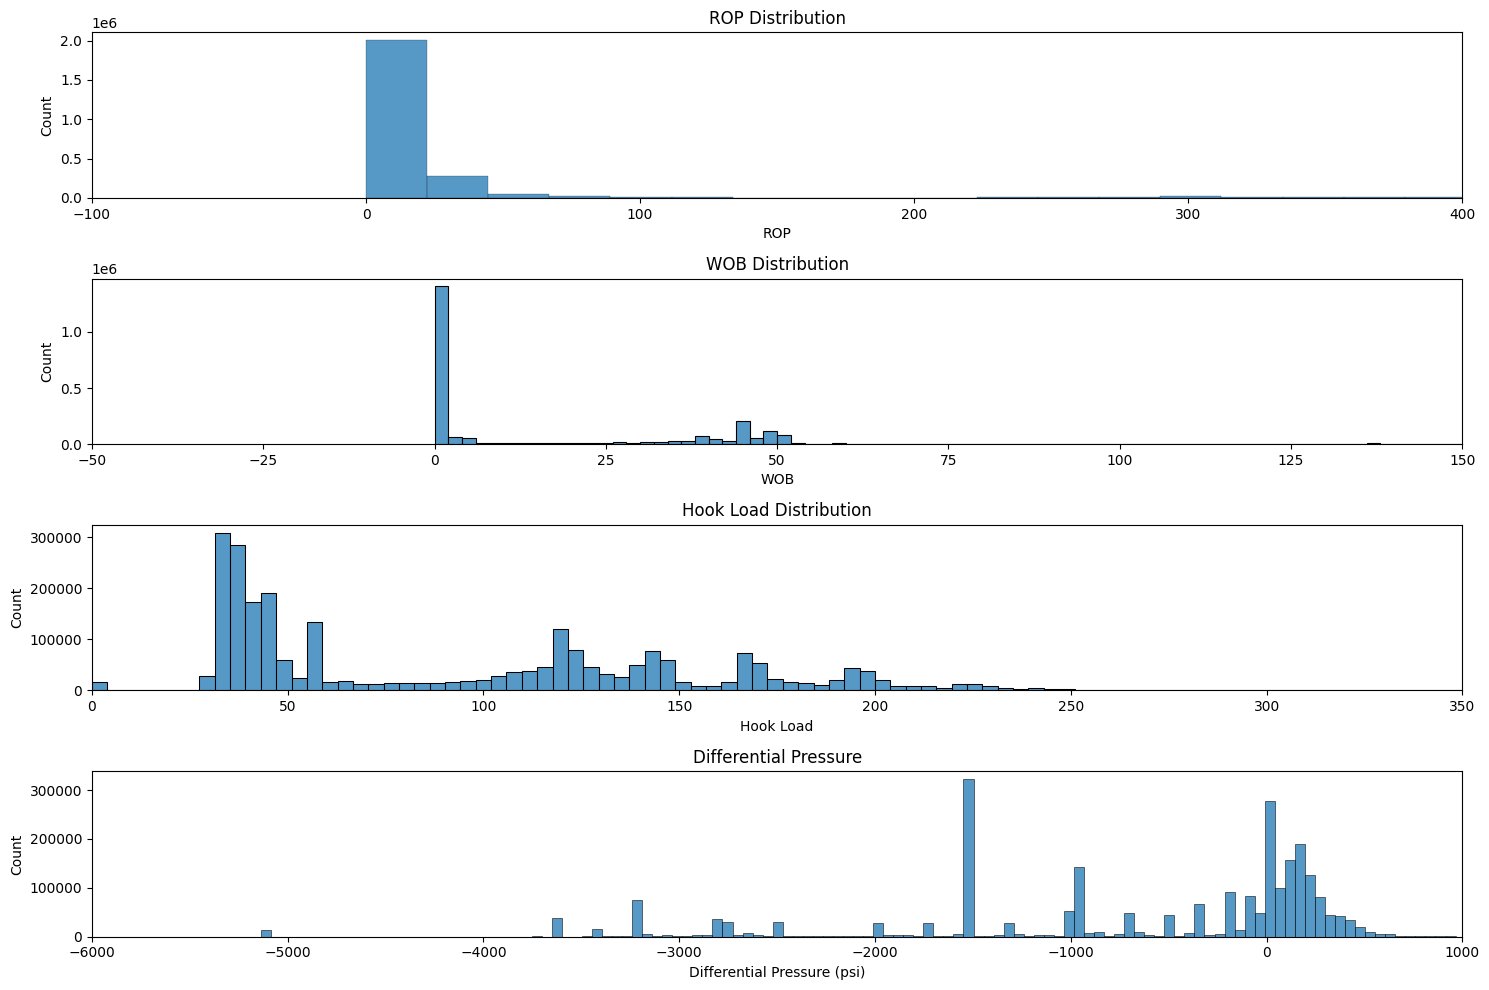

CPU times: user 2.71 s, sys: 340 ms, total: 3.05 s
Wall time: 3.23 s


In [10]:
%%time

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

# Define the data
data = df[["ROP", "WOB", "Hook Load", "Differential Pressure (psi)"]]

# Plot each histogram and set individual x-limits
sns.histplot(data=data, x="ROP", ax=axes[0], bins=500, edgecolor="black")
axes[0].set_xlim(-100, 400) 
axes[0].set_title("ROP Distribution")

sns.histplot(data=data, x="WOB", ax=axes[1], bins=200, binwidth=2, edgecolor="black")
axes[1].set_xlim(-50, 150)  
axes[1].set_title("WOB Distribution")

sns.histplot(data=data, x="Hook Load", ax=axes[2], bins=100, edgecolor="black")
axes[2].set_xlim(0, 350) 
axes[2].set_title("Hook Load Distribution")

sns.histplot(data=data, x="Differential Pressure (psi)", ax=axes[3], bins=200, edgecolor="black")
axes[3].set_xlim(-6000, 1000)
axes[3].set_title("Differential Pressure")

plt.tight_layout()
plt.show()

In [11]:
min_zero_cols = list(dict.fromkeys([
    "Azimuth (degrees)",
    "Hole Depth (feet)",
    "Bit Depth (feet)",
    "Hole Depth (feet)",
    "DAS BHA Stick Slip (unitless)",
    "Inclination (degrees)",
    "MWD Temp (Fahrenheit)",
    "Temp IN (Degrees)",
    "Temp OUT (Degrees)",
    "DAS Bit Stick Slip (unitless)"]))

df[min_zero_cols] = df[min_zero_cols].clip(lower=0)


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Hole Depth (feet),2506182.0,6.437759e+03,2.631146e+03,0.000,4502.600,7207.700,9034.000,9.147800e+03
Bit Depth (feet),2506182.0,4.536363e+03,3.091476e+03,0.000,1250.600,4646.200,7184.000,9.147800e+03
ROP,2506182.0,2.513907e+01,9.814824e+01,0.000,0.000,0.000,18.980,1.114593e+04
WOB,2506182.0,1.897934e+01,2.888804e+01,0.000,0.000,0.000,41.400,1.920000e+02
Hook Load,2506182.0,9.320549e+01,6.087874e+01,0.000,39.000,65.300,139.600,3.921000e+02
Rotary RPM (RPM),2506182.0,1.647774e+01,2.400560e+01,0.000,0.000,0.030,39.250,1.137900e+02
Standpipe Pressure (psi),2506182.0,1.196068e+03,1.486304e+03,0.000,0.000,0.000,2994.750,5.298750e+03
Rotary Torque (kft_lb),2506182.0,2.141682e+00,3.588161e+00,0.000,0.000,0.000,4.486,4.880900e+01
Differential Pressure (psi),2506182.0,-6.947406e+02,1.131267e+03,-5138.830,-1501.010,-124.330,130.950,5.119480e+03
Flow (flow_percent),2506182.0,3.148336e+01,3.483221e+01,-57.220,0.940,6.630,68.760,1.344300e+02


In [13]:
max_value_cols=['TTS Mechanical Specific Energy (ksi)','Relative MSE (unitless)','Mechanical Specific Energy (ksi)']
for col in max_value_cols:
    print(col, "| max values: ", df[col].max(), " min values: ", df[col].min())

TTS Mechanical Specific Energy (ksi) | max values:  17544615936.0  min values:  0.0
Relative MSE (unitless) | max values:  3603483590656.0  min values:  0.0
Mechanical Specific Energy (ksi) | max values:  43890704384.0  min values:  0.0


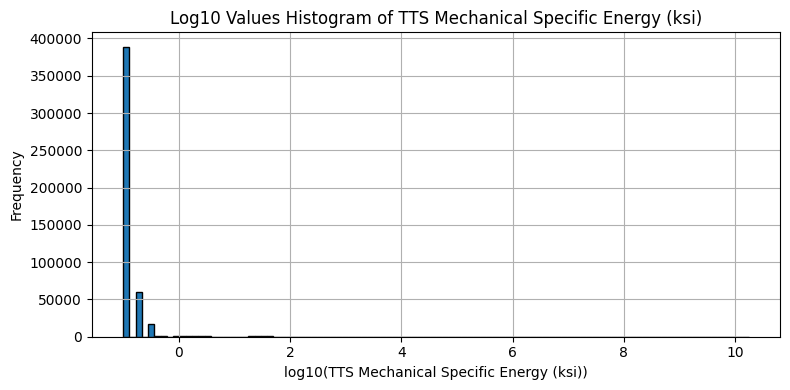

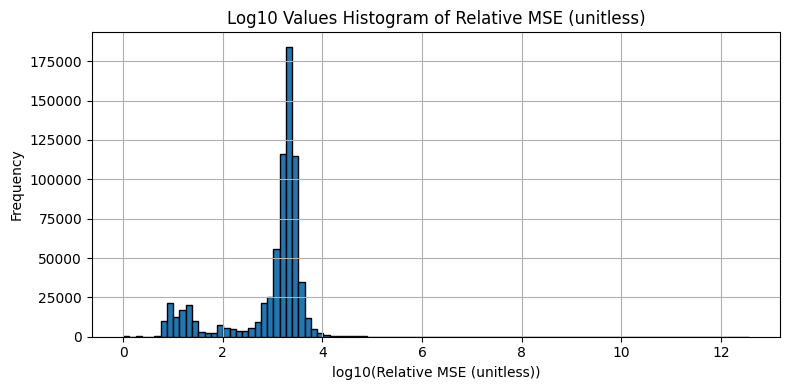

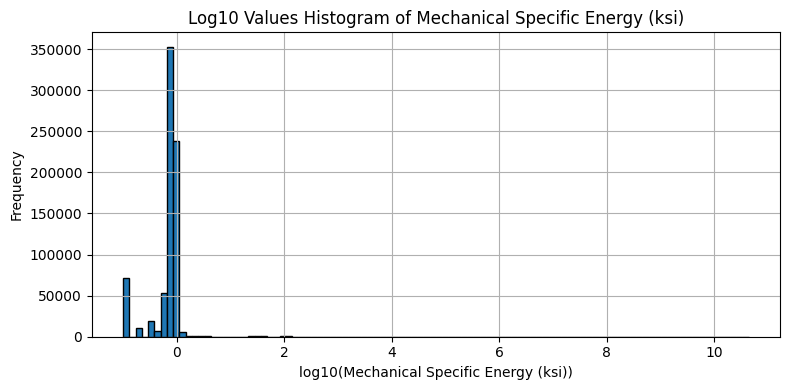

In [14]:
import numpy as np

mse_cols = [
    'TTS Mechanical Specific Energy (ksi)',
    'Relative MSE (unitless)',
    'Mechanical Specific Energy (ksi)'
]

for col in mse_cols:
    log_data = np.log10(df[col].replace(0, np.nan).dropna())  # avoid log(0)
    
    plt.figure(figsize=(8, 4))
    plt.hist(log_data, bins=100, edgecolor='black')
    plt.title(f"Log10 Values Histogram of {col}")
    plt.xlabel(f"log10({col})")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
df.loc[df['TTS Mechanical Specific Energy (ksi)'] > 500, 'TTS Mechanical Specific Energy (ksi)'] = np.nan
df.loc[df['Mechanical Specific Energy (ksi)'] > 500, 'Mechanical Specific Energy (ksi)'] = np.nan
df.loc[df['Relative MSE (unitless)'] > 1000, 'Relative MSE (unitless)'] = np.nan

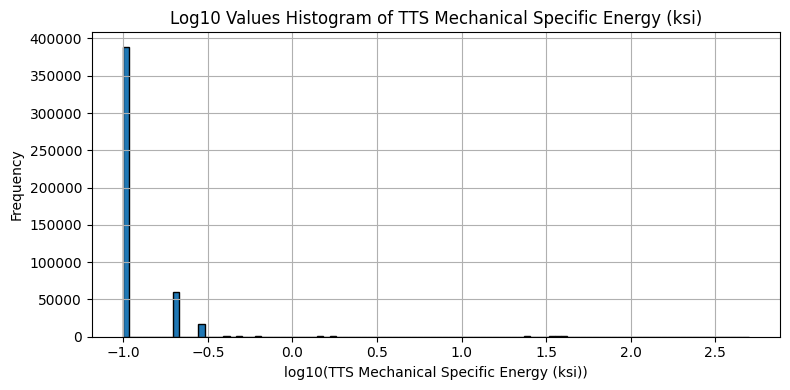

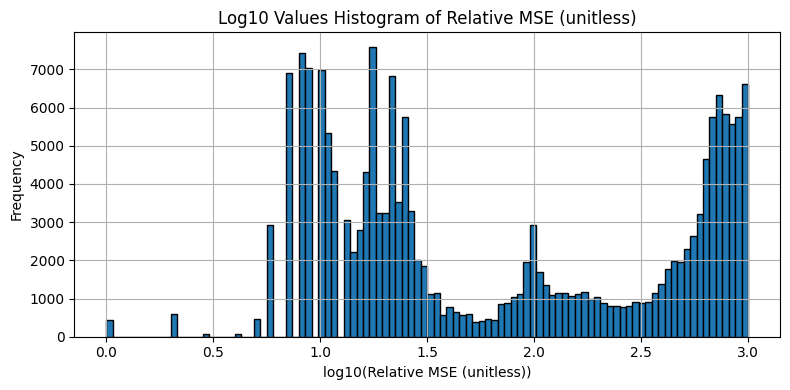

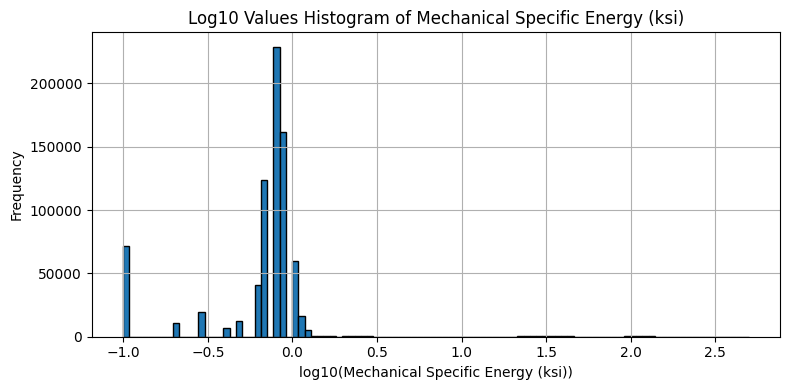

In [16]:
import numpy as np

for col in mse_cols:
    log_data = np.log10(df[col].replace(0, np.nan).dropna())  # avoid log(0)
    
    plt.figure(figsize=(8, 4))
    plt.hist(log_data, bins=100, edgecolor='black')
    plt.title(f"Log10 Values Histogram of {col}")
    plt.xlabel(f"log10({col})")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
df['Time'] = pd.to_datetime(df['YYYY/MM/DD'] + ' ' + df['HH:MM:SS'])

df.drop(columns=['YYYY/MM/DD','HH:MM:SS'], inplace=True)

df=df[['Time','Hole Depth (feet)', 'Bit Depth (feet)',
       'ROP', 'WOB', 'Hook Load', 'Rotary RPM (RPM)',
       'Standpipe Pressure (psi)', 'Rotary Torque (kft_lb)',
       'Differential Pressure (psi)', 'Flow (flow_percent)',
       'Total Pump Output (gal_per_min)', 'Pason Gas (percent)',
       'AutoDriller Torque (kft_lb)', 'AutoDriller WOB (klbs)',
       'Azimuth (degrees)', 'Bit RPM (RPM)', 'Bit Torque (kft_lb)',
       'DAS BHA Stick Slip (unitless)', 'DAS Bit Stick Slip (unitless)',
       'DAS Downhole MSE (ksi)', 'DAS MSE (ksi)',
       'DAS Recommended DIFFP (psi)', 'DAS Recommended ROP (ft_per_hr)',
       'DAS Recommended RPM (RPM)', 'DAS Recommended WOB (klbs)',
       'DAS ROP (ft_per_hr)', 'Depth of Cut (in)', 'dexponent (log)',
       'EDR Instantaneous ROP (ft_per_hr)', 'Hole Diameter (in)',
       'Inclination (degrees)', 'Mechanical Specific Energy (ksi)',
       'MWD Temp (Fahrenheit)', 'On Bottom (unitless)',
       'On Bottom ROP (ft_per_hr)', 'Relative MSE (unitless)',
       'Surface Stick Slip Index (percent)', 'Temp IN (Degrees)',
       'Temp OUT (Degrees)', 'Top Drive Rotary (RPM)',
       'Top Drive Torque (kft_lb)', 'TTS Mechanical Specific Energy (ksi)',
       ]]

In [18]:
df.head()

,Time,Hole Depth (feet),Bit Depth (feet),ROP,WOB,Hook Load,Rotary RPM (RPM),Standpipe Pressure (psi),Rotary Torque (kft_lb),Differential Pressure (psi),Flow (flow_percent),Total Pump Output (gal_per_min),Pason Gas (percent),AutoDriller Torque (kft_lb),AutoDriller WOB (klbs),Azimuth (degrees),Bit RPM (RPM),Bit Torque (kft_lb),DAS BHA Stick Slip (unitless),DAS Bit Stick Slip (unitless),DAS Downhole MSE (ksi),DAS MSE (ksi),DAS Recommended DIFFP (psi),DAS Recommended ROP (ft_per_hr),DAS Recommended RPM (RPM),DAS Recommended WOB (klbs),DAS ROP (ft_per_hr),Depth of Cut (in),dexponent (log),EDR Instantaneous ROP (ft_per_hr),Hole Diameter (in),Inclination (degrees),Mechanical Specific Energy (ksi),MWD Temp (Fahrenheit),On Bottom (unitless),On Bottom ROP (ft_per_hr),Relative MSE (unitless),Surface Stick Slip Index (percent),Temp IN (Degrees),Temp OUT (Degrees),Top Drive Rotary (RPM),Top Drive Torque (kft_lb),TTS Mechanical Specific Energy (ksi)
0,2021-02-08 04:30:00,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.96,42.44,0.0,0.005,0.0
1,2021-02-08 04:30:01,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.96,42.44,0.0,0.005,0.0
2,2021-02-08 04:30:02,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.96,42.44,0.0,0.005,0.0
3,2021-02-08 04:30:03,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.96,42.44,0.0,0.005,0.0
4,2021-02-08 04:30:04,174.5,98.9,0.0,0.0,56.8,0.03,0.0,0.005,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.98,42.51,0.0,0.005,0.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506182 entries, 0 to 2506181
Data columns (total 43 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   Time                                  datetime64[ns]
 1   Hole Depth (feet)                     float64       
 2   Bit Depth (feet)                      float64       
 3   ROP                                   float64       
 4   WOB                                   float64       
 5   Hook Load                             float64       
 6   Rotary RPM (RPM)                      float64       
 7   Standpipe Pressure (psi)              float64       
 8   Rotary Torque (kft_lb)                float64       
 9   Differential Pressure (psi)           float64       
 10  Flow (flow_percent)                   float64       
 11  Total Pump Output (gal_per_min)       float64       
 12  Pason Gas (percent)                   float64       
 13  AutoDriller 

## Mergin with Wireline Data

In [44]:
las=lasio.read("University_of_Utah_Forge_56_32_ThrubitDipole_Aniso_analysis_result_3452-9050ft_LAS.las")
df_wireline=las.df()

In [45]:
df_wireline.head()

,AZIM,BS_RM,C1_24,DEVI,DTCO_MPS_R,DTSH_FAST,DTSH_SLOW,FSA_ERRMINUS,FSA_ERRPLUS,FSA_NAZ_IN,FSA_TOH,GR_TMG,MAXXENE_OVERALL,MINXENE_OVERALL,PR_FAST,RB,SENSOR_AZIM_QCI,SLOANI,SPHI,TDIF_ALT_OVERALL,TDIF_ORG_OVERALL,TIMANI,TNPH,TW_B_L6,TW_E_L6,VPVS_FAST,XENEDIF
MD,,,,,,,,,,,,,,,,,,,,,,,,,,,
3452.0,0.0,8.75,8.9774,2.8034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.2895,NaN,NaN,NaN,312.53,NaN,NaN,NaN,NaN,NaN,NaN,0.1263,998.7773,1998.7773,NaN,NaN
3452.5,0.0,8.75,8.9726,2.6300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.1914,NaN,NaN,NaN,312.53,NaN,NaN,NaN,NaN,NaN,NaN,0.1341,998.7773,1998.7773,NaN,NaN
3453.0,0.0,8.75,8.9669,2.7123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.4440,NaN,NaN,NaN,311.87,NaN,NaN,NaN,NaN,NaN,NaN,0.1384,998.7773,1998.7773,NaN,NaN
3453.5,0.0,8.75,8.9632,2.7898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.8437,NaN,NaN,NaN,311.87,NaN,NaN,NaN,NaN,NaN,NaN,0.1456,998.7773,1998.7773,NaN,NaN
3454.0,0.0,8.75,8.9603,2.8729,52.7234,98.3777,99.3549,NaN,NaN,NaN,NaN,84.7917,NaN,NaN,0.2985,311.96,NaN,0.9884,0.0362,NaN,NaN,NaN,0.1558,998.7773,1998.7773,1.8659,NaN


In [46]:
df_wireline=df_wireline[['GR_TMG', 'DTCO_MPS_R','TNPH']]

In [47]:
df_wireline.head()

,GR_TMG,DTCO_MPS_R,TNPH
MD,,,
3452.0,80.2895,NaN,0.1263
3452.5,84.1914,NaN,0.1341
3453.0,89.4440,NaN,0.1384
3453.5,88.8437,NaN,0.1456
3454.0,84.7917,52.7234,0.1558


### Note

Distribution of GR over the depth is used to understand selection of interpolant.



#### What the Depth Spacing Tells Us:

- If all depth intervals are 0.5 ft, then the data is uniformly spaced.

- This regularity makes linear interpolation an appropriate and efficient choice (kind="linear").

Mean spacing: 0.5
Min spacing: 0.5
Max spacing: 0.5




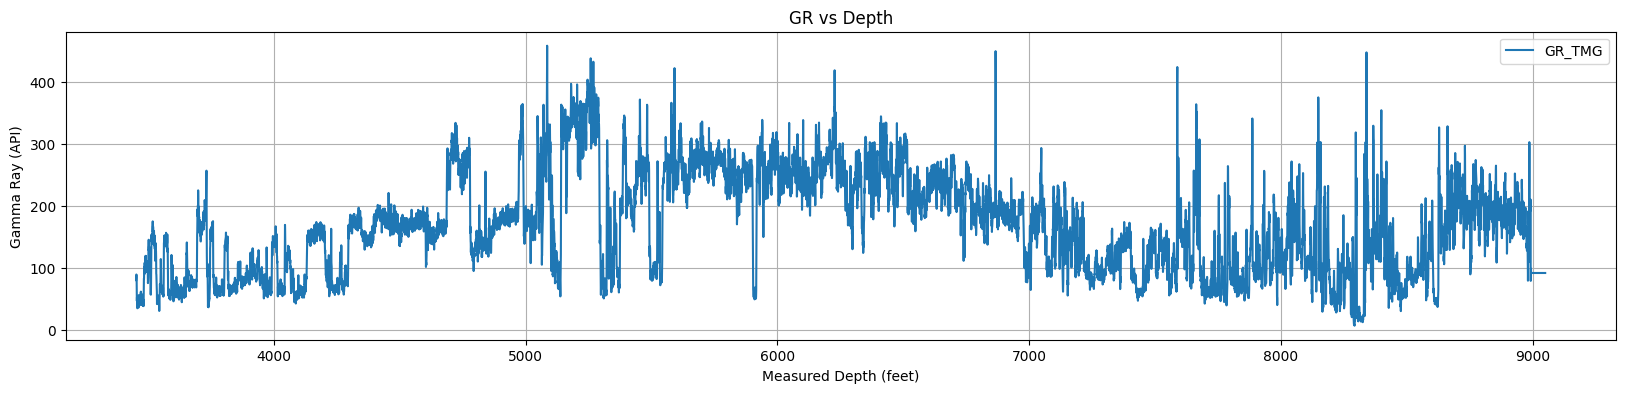

In [48]:
wireline_depths = df_wireline.index.values
depth_diff = np.diff(wireline_depths)
print("Mean spacing:", np.mean(depth_diff))
print("Min spacing:", np.min(depth_diff))
print("Max spacing:", np.max(depth_diff))
print("\n")
plt.figure(figsize=(20, 4))
plt.plot(df_wireline.index, df_wireline['GR_TMG'], label='GR_TMG')
plt.xlabel("Measured Depth (feet)")
plt.ylabel("Gamma Ray (API)")
plt.title("GR vs Depth")
plt.grid(True)
plt.legend()
plt.show()


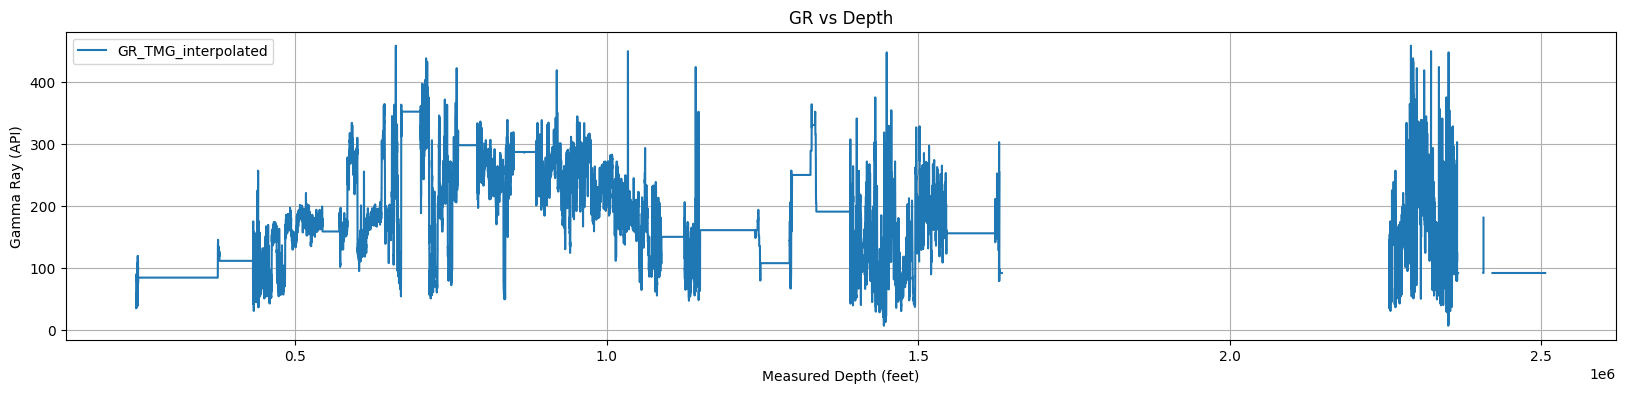

In [54]:
plt.figure(figsize=(20, 4))
plt.plot(df.index, df['GR_TMG_interpolated'], label='GR_TMG_interpolated')
plt.xlabel("Measured Depth (feet)")
plt.ylabel("Gamma Ray (API)")
plt.title("GR vs Depth")
plt.grid(True)
plt.legend()
plt.show()


In [52]:
from scipy.interpolate import interp1d
import numpy as np

interp_gr = interp1d(df_wireline.index, df_wireline['GR_TMG'], kind='linear', bounds_error=False, fill_value=np.nan)
interp_dtco = interp1d(df_wireline.index, df_wireline['DTCO_MPS_R'], kind='linear', bounds_error=False, fill_value=np.nan)
interp_tnph = interp1d(df_wireline.index, df_wireline['TNPH'], kind='linear', bounds_error=False, fill_value=np.nan)

# Step 3: Interpolate directly into drilling DataFrame
df['GR_TMG_interpolated'] = interp_gr(df['Hole Depth (feet)'])
df['DTCO_interpolated'] = interp_dtco(df['Hole Depth (feet)'])
df['TNPH_interpolated'] = interp_tnph(df['Hole Depth (feet)'])


In [53]:
df.columns

Index(['YYYY/MM/DD', 'HH:MM:SS', 'Hole Depth (feet)', 'Bit Depth (feet)',
       'ROP', 'WOB', 'Hook Load', 'Rotary RPM (RPM)',
       'Standpipe Pressure (psi)', 'Rotary Torque (kft_lb)',
       'Differential Pressure (psi)', 'Flow (flow_percent)',
       'Total Pump Output (gal_per_min)', 'Pason Gas (percent)',
       'AutoDriller Torque (kft_lb)', 'AutoDriller WOB (klbs)',
       'Azimuth (degrees)', 'Bit RPM (RPM)', 'Bit Torque (kft_lb)',
       'DAS BHA Stick Slip (unitless)', 'DAS Bit Stick Slip (unitless)',
       'DAS Downhole MSE (ksi)', 'DAS MSE (ksi)',
       'DAS Recommended DIFFP (psi)', 'DAS Recommended ROP (ft_per_hr)',
       'DAS Recommended RPM (RPM)', 'DAS Recommended WOB (klbs)',
       'DAS ROP (ft_per_hr)', 'Depth of Cut (in)', 'dexponent (log)',
       'EDR Instantaneous ROP (ft_per_hr)', 'Hole Diameter (in)',
       'Inclination (degrees)', 'Mechanical Specific Energy (ksi)',
       'MWD Temp (Fahrenheit)', 'On Bottom (unitless)',
       'On Bottom ROP (ft_per_h

In [26]:
df.dropna(inplace=True)

In [27]:
df = df.dropna(subset=['GR_TMG_interpolated', 'DTCO_interpolated', 'TNPH_interpolated'])

In [28]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Time,1059410,2021-02-22 06:01:17.190936576,2021-02-11 00:44:22,2021-02-16 02:23:32.249999872,2021-02-21 21:49:35.500000,2021-02-26 07:29:22.750000128,2021-03-09 06:00:00,NaN
Hole Depth (feet),1059410.0,6472.530427,3454.0,4604.9,7207.7,7666.9,9036.5,1935.801704
Bit Depth (feet),1059410.0,3943.280213,0.0,1197.4,3587.45,6092.075,9036.5,2773.883825
ROP,1059410.0,25.355725,0.0,0.0,0.0,0.0,10814.49,102.786936
WOB,1059410.0,14.568613,0.0,0.0,0.0,18.6,184.6,28.902987
Hook Load,1059410.0,94.004933,0.0,38.5,53.3,144.9,392.1,66.020642
Rotary RPM (RPM),1059410.0,10.187572,0.0,0.0,0.03,0.55,109.22,20.170367
Standpipe Pressure (psi),1059410.0,972.548303,0.0,0.0,0.0,2418.565,4676.78,1382.529875
Rotary Torque (kft_lb),1059410.0,1.256196,0.0,0.0,0.0,0.126,48.809,3.276075
Differential Pressure (psi),1059410.0,-816.125147,-3650.01,-1797.2,-170.57,12.95,3335.69,1247.096212


### Note

Corolation between the the gamma values and other parameters.

In [29]:
corr = df.corr()

[]

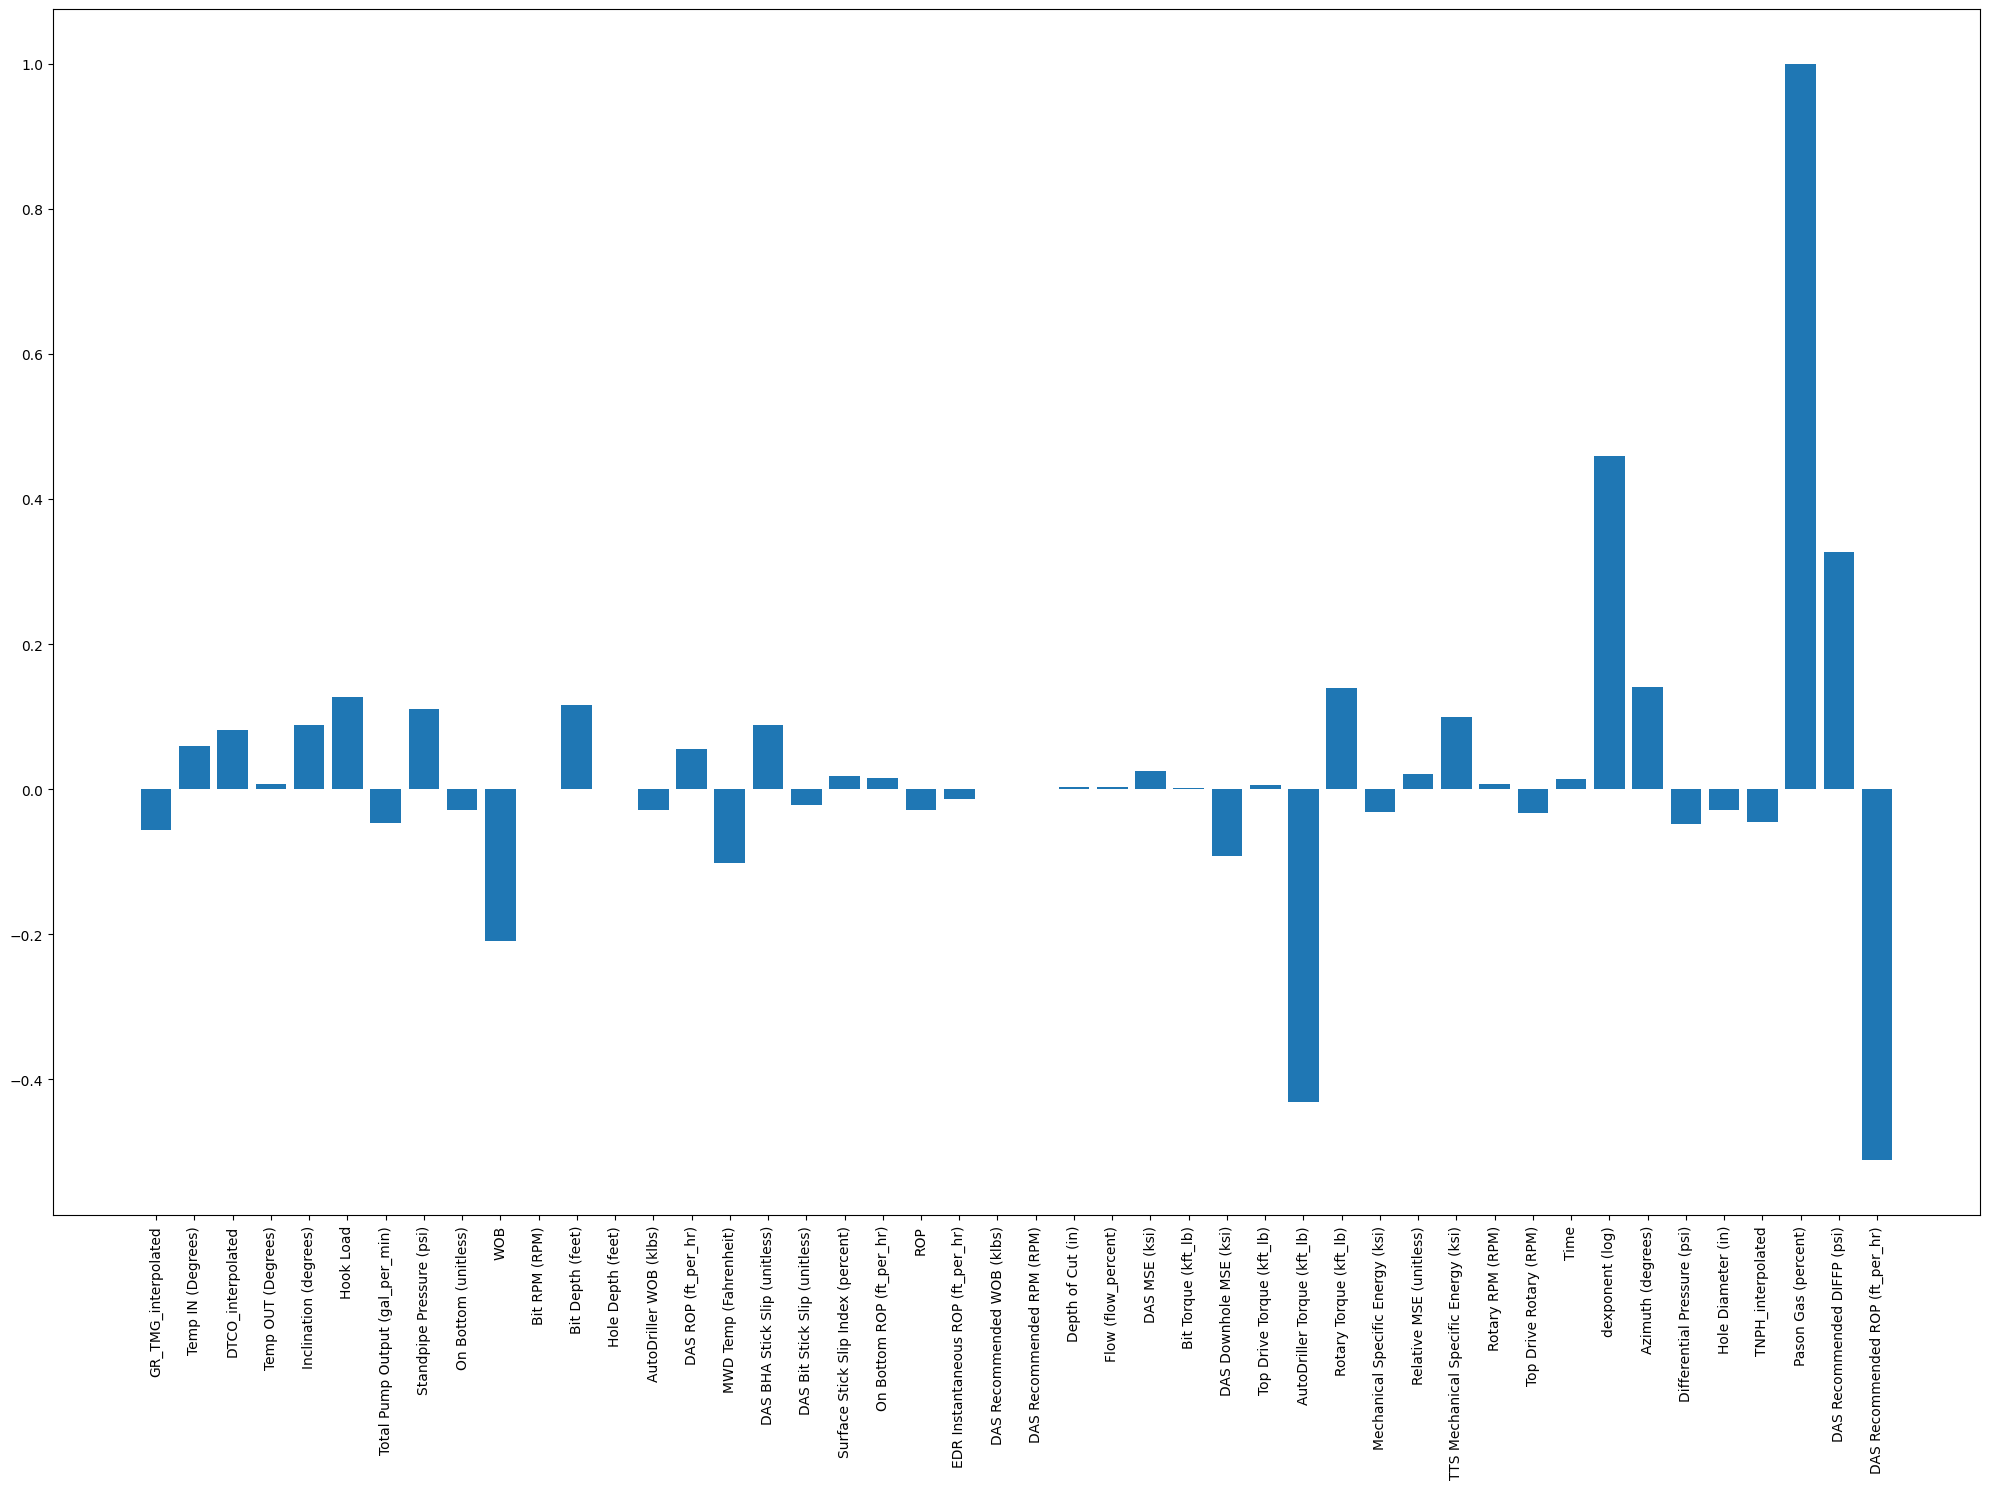

In [30]:
plt.figure(figsize=(20,15))
data=corr['GR_TMG_interpolated'].sort_values(ascending=False)
plt.bar(data=data, x=data.index, height=corr['GR_TMG_interpolated'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.plot()

## Exporting

In [32]:
df.to_csv("Merged_data.csv")